<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Plan-of-Action" data-toc-modified-id="Plan-of-Action-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plan of Action</a></span></li><li><span><a href="#Dataset-Exploration" data-toc-modified-id="Dataset-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset Exploration</a></span><ul class="toc-item"><li><span><a href="#Applications" data-toc-modified-id="Applications-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Applications</a></span></li><li><span><a href="#Bureau-and-Bureau-Balance" data-toc-modified-id="Bureau-and-Bureau-Balance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Bureau and Bureau Balance</a></span></li><li><span><a href="#Previous-Applications" data-toc-modified-id="Previous-Applications-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Previous Applications</a></span></li><li><span><a href="#Point-of-Sales" data-toc-modified-id="Point-of-Sales-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Point of Sales</a></span></li><li><span><a href="#Instalment-Payments" data-toc-modified-id="Instalment-Payments-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Instalment Payments</a></span></li><li><span><a href="#Credit-Card-Balances" data-toc-modified-id="Credit-Card-Balances-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Credit Card Balances</a></span></li></ul></li><li><span><a href="#Data-Merging" data-toc-modified-id="Data-Merging-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Merging</a></span></li></ul></div>

# Overview

# Plan of Action

This is a complex project with a large amount of data and multiple data sets that need to be processed. We'll roughly follow the following plan of action:

- Import each of the datasets and perform some basic visualisation. We'll look at distributions, correlations, outliers and missing values to give ourselves a sense of what we are dealing with and any data cleaning operations that will be required.
- We need to aggregate the data from the various datasets into our main training and test sets in order to perform machine learning. 
- Once we have a clean, prepared single dataset, we'll get a baseline model using default or basic hyperparaters for scikit's `GradientBoostingClassifier`, `XGBoost` and `LightGBM`. We'll limit ourselves to only these three models since they tend to be the most successful in Kaggle competitions and for this type of project. 
- After getting a baseline score, we'll explore data with a view towards feature engineering and iterative improvement of our score. We're going to spend most of our time here. If need be, we'll look into automated feature engineering tools such as `featuretools`. Only once we've absolutely exhausted our creativity for feature creation, will we move on to model tuning. We'll use the area under the ROC curve for our scoring. 
- To tune our model, we'll experiment with randomised cross-validation and Bayesian Optimisation to identify the best model parameters. 

Much of the process will be iterative and we'll submit a score to Kaggle following each round of feature engineering or model tuning. We may have to return to previously completed steps if we learn something new. Based on what others have said on Kaggle, processing time may become an issue in which case we may look to set up our jupyter notebook on an AWS EC2 instance that is GPU-enabled and run our analysis there.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

pd.options.display.max_columns = 1000

import warnings
warnings.filterwarnings('ignore')

# Dataset Exploration

## Applications

In [2]:
# list out files in our input directory
print(os.listdir("input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
app_train = pd.read_csv('input/application_train.csv')
print("training data size:", app_train.shape)
app_train.head()

training data size: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [4]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

- `SK_ID_CURR` is the primary identifier of the client, we'll use this to join the other datasets after their data has been aggregated. 
- `TARGET` is our target variable, indicating 0: the loan was repaid or 1: the loan was not repaid.
- A number of flag fields with binary values as well as categorical fields, these can all be encoded using one-hot encoding.
- A number of day fields with negative values, presumbly counting from the loan application date. We aren't given the exact application date, just these relative fields. 
- Fields are a mix of loan specific and socio-economic variables. 
- `EXT_SOURCE_1/2/3` are normalised fields from some unknown externel source. 
- There are a whole suite of fields pertaining to the building where the client lives > most probably aren't useful but we'll see.
- `OBS_30/DEF_30/OBS_60_/DEF_60_CNT_SOCIAL_CIRCLE` - interesting fields, the number of observations in the clien't social surrounding who have default in various time brackets. An indication of the socio-economic conditions in the surrounding area perhaps?
- `FLAG_DOCUMENT` fields - did the client provide a specific document.
- `AMT_REQ` fields - the number of enquiries to the credit bureau about the client, specific to different time initervals before the application date.

Let's check if the days-related variables make sense by dividing them by 365 and getting the absolute value to determine how many years from the application date they refer.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002347152E828>,
      dtype=object)

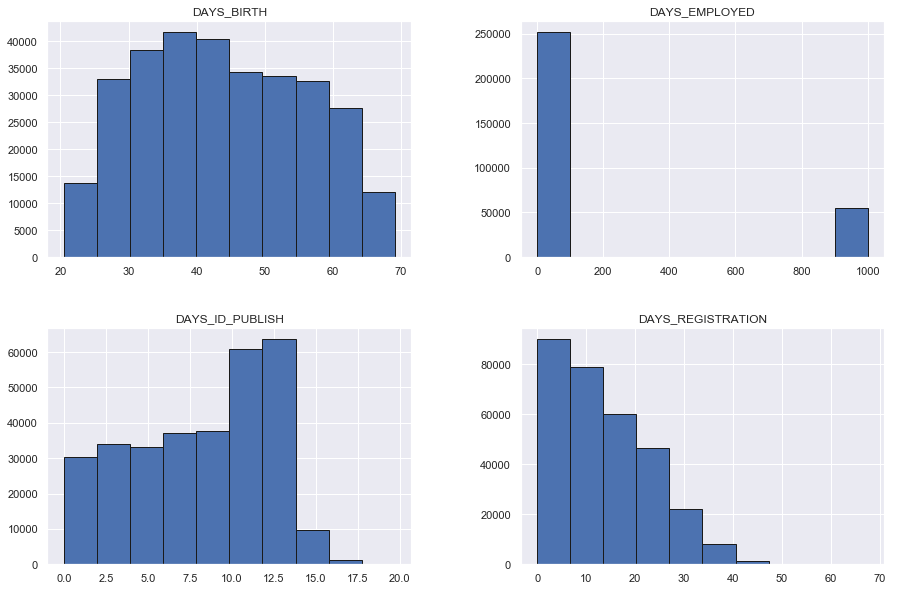

In [5]:
cols = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
fig, ax = plt.subplots(figsize=(15, 10))
np.abs(app_train[cols]/365).hist(ax=ax, edgecolor = 'k')

Most of the values are reasonable except `DAYS_EMPLOYED`, people have been employed 900 years, this is obviously an error. We'll correct it by changing these values to `np.nan`. This will allow them to be imputed with means later, which will be more accurate.

In [6]:
app_train["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

There's the culprit! 365243 days employed. Let's see how many records have this value and then replace them.

In [7]:
app_train[app_train["DAYS_EMPLOYED"] == 365243]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,913500.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,NaN,1,0,0,1,0,0,NaN,2.0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0.587334,0.205747,0.751724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,10678.5,135000.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.015221,-20417,365243,-5246.0,-2512,NaN,1,0,0,1,1,0,NaN,2.0,2,2,FRIDAY,7,0,0,0,0,0,0,XNA,0.722044,0.555183,0.652897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2396.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,23850.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.006296,-24827,365243,-9012.0,-3684,NaN,1,0,0,1,1,0,NaN,2.0,3,3,FRIDAY,12,0,0,0,0,0,0,XNA,NaN,0.624305,0.669057,0.1443,0.0848,0.9876,0.8300,0.1064,0.1400,0.1207,0.3750,0.4167,0.2371,0.1173,0.1484,0.0019,0.0007,0.1261,0.0754,0.9876,0.8367,0.0000,0.1208,0.1034,0.3750,0.4167,0.2425,0.1102,0.0923,0.0000,0.0000,0.1457,0.0848,0.9876,0.8323,0.1071,0.14,0.1207,0.3750,0.4167,0.2412,0.1193,0.1510,0.0019,0.0007,org spec account,block of flats,0.1640,Mixed,No,0.0,0.0,0.0,0.0,-795.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
38,100045,0,Cash loans,F,N,Y,0,99000.000

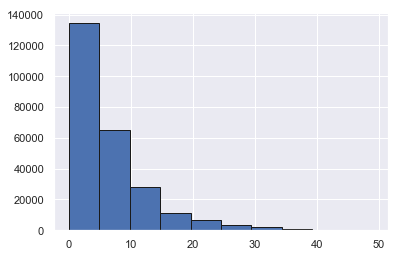

In [8]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
np.abs(app_train['DAYS_EMPLOYED']/365).hist(edgecolor = 'k')

Let's check the the gender field to make sure there isn't anything unusual here.

In [9]:
app_train.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Not sure what XNA means but there are only 4 records with this value, so let's remove them entirely. 

In [10]:
app_train = app_train[app_train.CODE_GENDER != "XNA"]
app_train.CODE_GENDER.value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

Let's check if the number of children people have seems reasonable.

In [11]:
app_train.CNT_CHILDREN.describe()

count    307507.000000
mean          0.417047
std           0.722119
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

Someone has 19 children, this probably isn't correct, we'll investigate.

In [12]:
app_train[app_train.CNT_CHILDREN > 9]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
34545,140032,1,Cash loans,M,Y,N,11,315000.0,1007761.5,38515.5,927000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-17308,-198.0,-3940.0,-844,12.0,1,1,0,1,0,0,Managers,13.0,2,2,FRIDAY,17,0,0,0,0,1,1,Other,0.134587,0.567454,0.122955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-3.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
80948,193853,0,Cash loans,F,N,Y,12,337500.0,746280.0,59094.0,675000.0,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,0.046220,-14093,-2710.0,-2066.0,-3908,NaN,1,1,0,1,0,0,Core staff,14.0,1,1,FRIDAY,13,0,0,0,0,0,0,Kindergarten,0.641817,0.703253,0.132597,0.0062,0.0164,0.9727,0.6260,0.0120,0.0000,0.0345,0.1667,0.2083,0.0000,0.0050,0.0524,0.0,0.0000,0.0063,0.0170,0.9727,0.6406,0.0121,0.0,0.0345,0.1667,0.2083,0.0000,0.0055,0.0546,0.0,0.000,0.0062,0.0164,0.9727,0.6310,0.0121,0.00,0.0345,0.1667,0.2083,0.0000,0.0051,0.0534,0.0,0.0000,org spec account,block of flats,0.0412,"Stone, brick",No,3.0,2.0,3.0,1.0,-357.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
132585,253779,0,Cash loans,F,N,Y,10,67500.0,92655.0,5301.0,76500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.018850,-11458,-742.0,-5278.0,-1186,NaN,1,1,0,1,0,0,Core staff,12.0,2,2,FRIDAY,10,0,0,0,0,0,0,School,0.686645,0.640388,0.639708,0.1649,NaN,0.9906,NaN,NaN,NaN,0.1379,0.3750,NaN,NaN,NaN,0.1008,NaN,0.0113,0.1681,NaN,0.9906,NaN,NaN,NaN,0.1379,0.3750,NaN,NaN,NaN,0.1050,NaN,0.012,0.1665,NaN,0.9906,NaN,NaN,NaN,0.1379,0.3750,NaN,NaN,NaN,0.1026,NaN,0.0116,NaN,block of flats,0.1372,Panel,No,0.0,0.0

We'll replace this with `np.nan` so they can be imputed later.

In [13]:
app_train.loc[app_train[app_train.CNT_CHILDREN > 9].index, "CNT_CHILDREN"] = np.nan

In [14]:
app_train[app_train.CNT_CHILDREN > 9].shape[0]

0

We'll search for outliers in some of our loan-specific numeric variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023408176B00>,
      dtype=object)

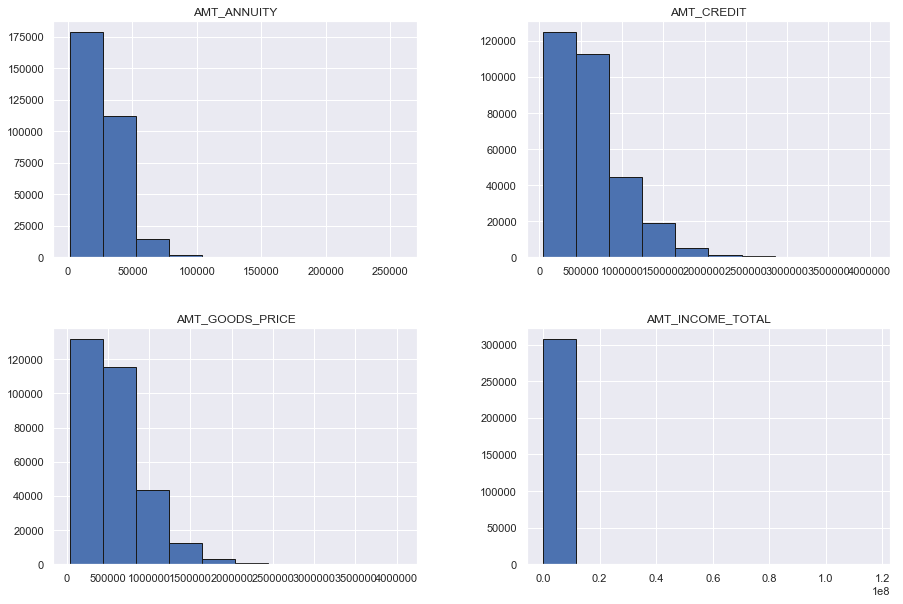

In [15]:
cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]
f, ax = plt.subplots(figsize=(15,10))
app_train[cols].hist(ax=ax, edgecolor = 'k')

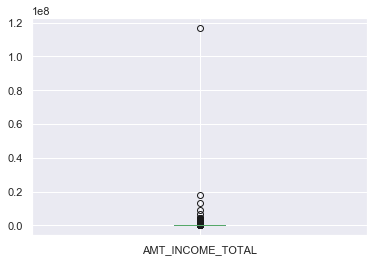

In [16]:
app_train["AMT_INCOME_TOTAL"].plot(kind="box")

Someone is very rich! But it's not neccessarily incorrect. 

In [17]:
app_train[app_train["AMT_INCOME_TOTAL"] > 10000000]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
12840,114967,1,Cash loans,F,N,Y,1.0,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922.0,-6762.0,-3643,NaN,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.460809,0.113161,0.145543,0.1031,0.0947,0.9791,NaN,NaN,0.0,0.2069,0.1667,NaN,0.0688,NaN,0.0615,NaN,NaN,0.105,0.0983,0.9791,NaN,NaN,0.0,0.2069,0.1667,NaN,0.0704,NaN,0.0641,NaN,NaN,0.1041,0.0947,0.9791,NaN,NaN,0.0,0.2069,0.1667,NaN,0.07,NaN,0.0626,NaN,NaN,NaN,block of flats,0.0715,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
203693,336147,0,Cash loans,M,Y,Y,2.0,18000090.0,675000.0,69295.5,675000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.030755,-15704,-4961.0,-3338.0,-4728,7.0,1,1,0,1,0,0,NaN,4.0,2,2,THURSDAY,22,0,0,0,0,0,0,Business Entity Type 3,0.543417,0.788606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1133.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246858,385674,0,Cash loans,M,Y,Y,0.0,13500000.0,1400503.5,130945.5,1368000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.030755,-13551,-280.0,-3953.0,-4972,10.0,1,1,1,1,0,0,NaN,2.0,2,2,SUNDAY,12,0,0,0,0,0,0,Business Entity Type 3,NaN,0.713507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-13.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Would someone with this much money need a loan and then not be able to pay it back? I doubt it. I'll replace these values with `np.nan` so they can be inputed later.

In [18]:
app_train.loc[app_train[app_train["AMT_INCOME_TOTAL"] > 10000000].index, "AMT_INCOME_TOTAL"] = np.nan

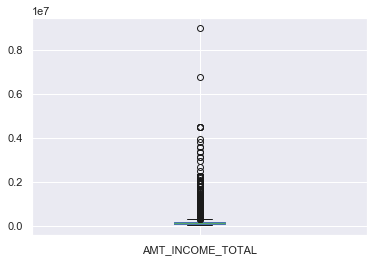

In [19]:
app_train["AMT_INCOME_TOTAL"].plot(kind="box")

## Bureau and Bureau Balance

In [20]:
bureau = pd.read_csv('input/bureau.csv')
print("bureau data size:", bureau.shape)
bureau.head()

bureau data size: (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [21]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

- `SK_ID_CURR` is foreign key to main application table. `SK_ID_BUREAU` is unique key of loan that client previously had as logged in the credit bureau. In order to join this data with the main table, we'll need to decide how we want to represent each individual previous loan and how we'll deal with categorical variables. 

Let's check the days fields like we did previously.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023408975898>,
      dtype=object)

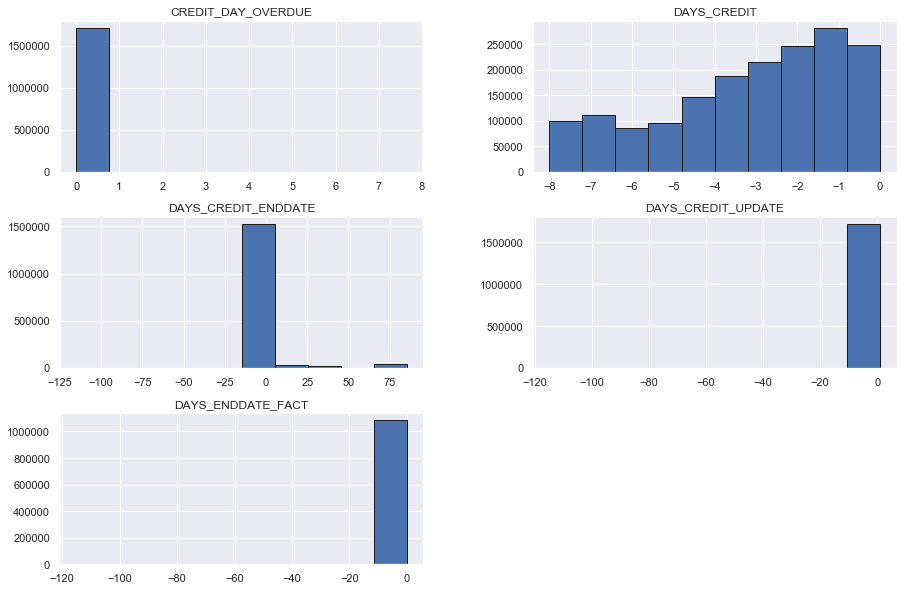

In [22]:
cols = ["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE"]
f, ax = plt.subplots(figsize=(15, 10))
(bureau[cols]/365).hist(ax=ax, edgecolor='k')

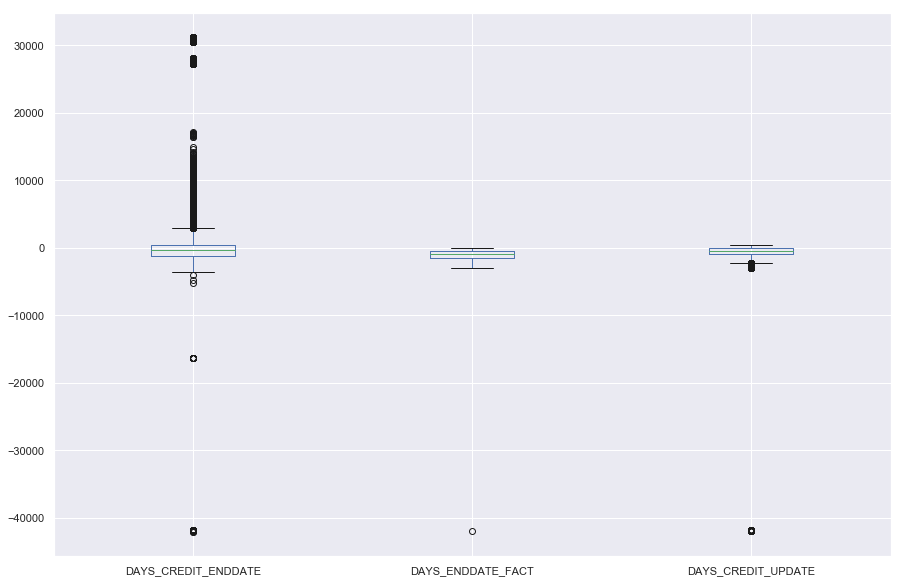

In [23]:
cols = ["DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE"]
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

Some of these outliers don't make sense, a value of 40,000 days for `DAYS_CREDIT_ENDDATE` means that the their current loan with the bureau has 109 years to go. I'm going to replace value below -20,000 with `np.nan` for these 3 fields.

In [24]:
bureau.loc[bureau[bureau["DAYS_CREDIT_ENDDATE"] < -20000].index, "DAYS_CREDIT_ENDDATE"] = np.nan
bureau.loc[bureau[bureau["DAYS_ENDDATE_FACT"] < -20000].index, "DAYS_ENDDATE_FACT"] = np.nan
bureau.loc[bureau[bureau["DAYS_CREDIT_UPDATE"] < -20000].index, "DAYS_CREDIT_UPDATE"] = np.nan

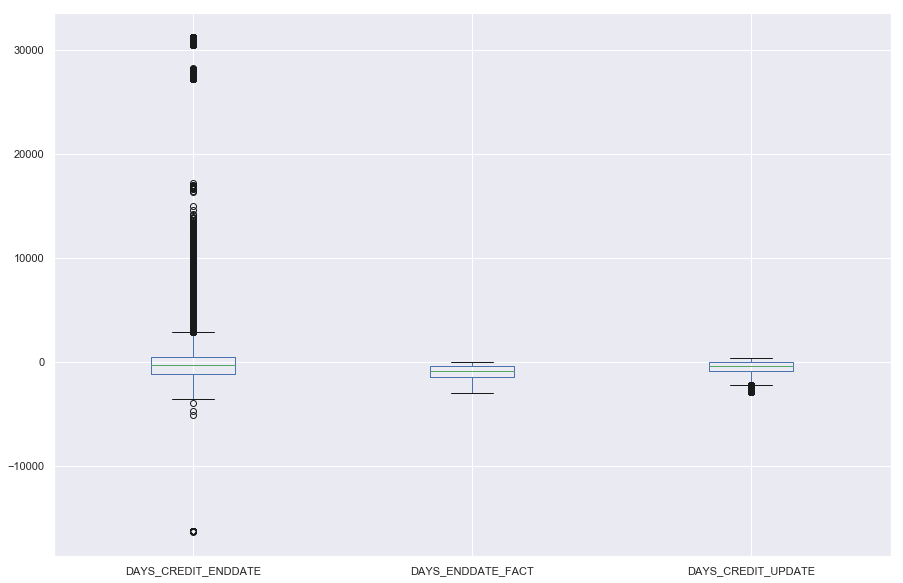

In [25]:
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

Also should there be positive and negative values for DAYS_CREDIT_ENDDATE when its definition seems to be the days until loan is repayed? 

In [26]:
bureau[bureau["DAYS_CREDIT_ENDDATE"] > 0].shape[0]

602603

In [27]:
bureau[bureau["DAYS_CREDIT_ENDDATE"] < 0].shape[0]

1007255

There are a large number of both thus I'm hesitant to change any of them. We'll leave for now. Let's investigate some other important fields.

In [28]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131.0,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20.0,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16.0,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16.0,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21.0,NaN


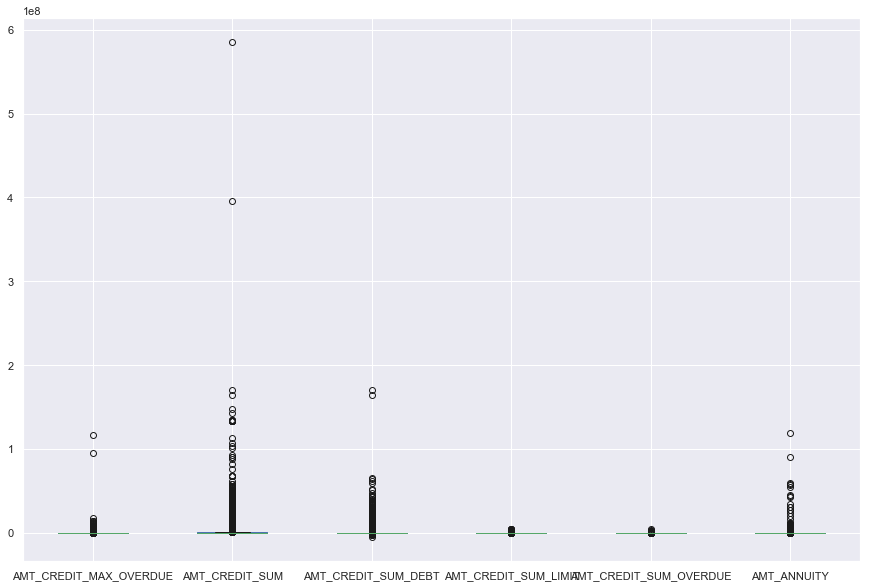

In [29]:
cols = ["AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

In [30]:
bureau[bureau.AMT_CREDIT_SUM > 300000000]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
907821,325979,5671169,Closed,currency 1,-2867,0,-2833.0,-2830.0,NaN,0,396000000.0,0.0,0.0,0.0,Consumer credit,-1400.0,NaN
1515147,386819,6706880,Closed,currency 1,-2683,0,-2318.0,-2312.0,NaN,0,585000000.0,NaN,NaN,0.0,Consumer credit,-2312.0,NaN


This doesn't look right, a credit amount of over \$300,000,000 must be an error. It will be replaced with `np.nan`

In [31]:
bureau.loc[bureau[bureau.AMT_CREDIT_SUM > 300000000].index, "AMT_CREDIT_SUM"] = np.nan

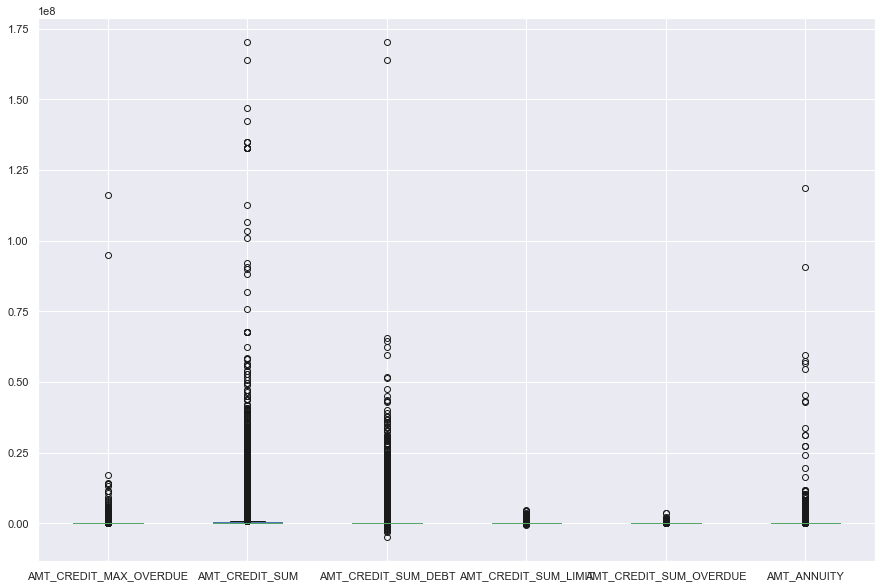

In [32]:
cols = ["AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

In [33]:
bureau[cols].describe()

,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
count,5.919400e+05,1.716413e+06,1.458759e+06,1.124648e+06,1.716428e+06,4.896370e+05
mean,3.825418e+03,3.544235e+05,1.370851e+05,6.229515e+03,3.791276e+01,1.571276e+04
std,2.060316e+05,1.015739e+06,6.774011e+05,4.503203e+04,5.937650e+03,3.258269e+05
min,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,1.350000e+04
max,1.159872e+08,1.701000e+08,1.701000e+08,4.705600e+06,3.756681e+06,1.184534e+08


I'm somewhat comfused by these huge credit sums, debt and annuities. Since these values are for debts outside of Home Credit, it's possible that some of these are for momrgages etc. but still an annuity of \$125,000,000 can't be right. Then there is also a strange mix of positive and negative values.

I'm going to mark as `np.nan` any of the outliers that are greater than 3 x IQR range. We'll handle `AMT_CREDIT_MAX_OVERDUE`, `AMT_CREDIT_SUM_LIMIT` and `AMT_CREDIT_SUM_OVERDUE` later as their IQR range is 0, thus if this rule would remove all their values. I'd like to investigate their split between positive and negative values as well.

In [34]:
cols = ["AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_ANNUITY"]
iqr = bureau[cols].describe().loc["75%"] - bureau[cols].describe().loc["25%"]
iqr

AMT_CREDIT_SUM         263700.0
AMT_CREDIT_SUM_DEBT     40153.5
AMT_ANNUITY             13500.0
dtype: float64

In [35]:
bureau.loc[bureau[bureau.AMT_CREDIT_SUM >= 3*iqr.AMT_CREDIT_SUM].index, "AMT_CREDIT_SUM"] = np.nan
bureau.loc[bureau[bureau.AMT_CREDIT_SUM_DEBT >= 3*iqr.AMT_CREDIT_SUM_DEBT].index, "AMT_CREDIT_SUM_DEBT"] = np.nan
bureau.loc[bureau[bureau.AMT_ANNUITY >= 3*iqr.AMT_ANNUITY].index, "AMT_ANNUITY"] = np.nan

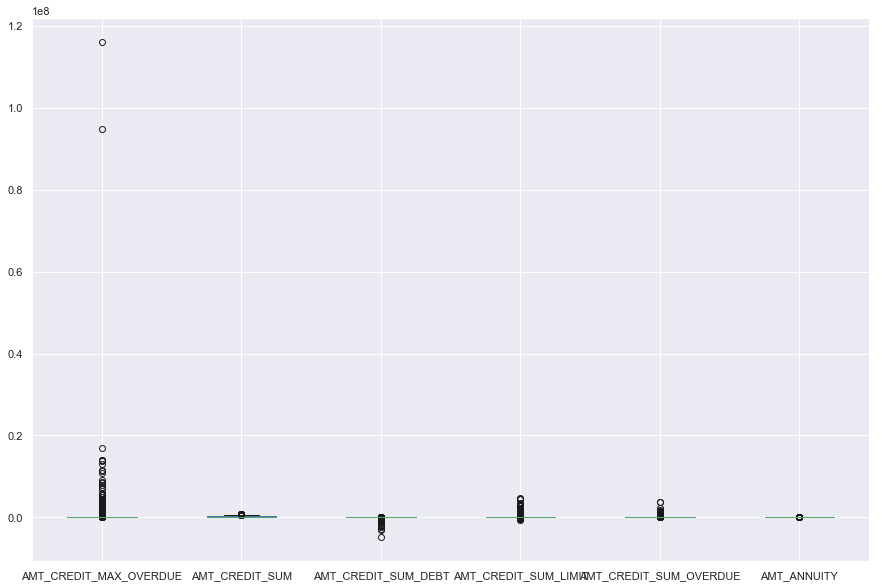

In [36]:
cols = ["AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

Now let's treat `AMT_CREDIT_MAX_OVERDUE`, `AMT_CREDIT_SUM_LIMIT` and `AMT_CREDIT_SUM_OVERDUE`

In [38]:
bureau[cols].describe()

,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY
count,5.919400e+05,1.546355e+06,1.199945e+06,1.124648e+06,1.716428e+06,456836.000000
mean,3.825418e+03,1.670761e+05,7.847031e+03,6.229515e+03,3.791276e+01,6334.470328
std,2.060316e+05,1.704662e+05,2.450823e+04,4.503203e+04,5.937650e+03,9671.542626
min,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,0.000000
25%,0.000000e+00,4.531500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,1.050795e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,0.000000e+00,2.250000e+05,0.000000e+00,0.000000e+00,0.000000e+00,10435.500000
max,1.159872e+08,7.910899e+05,1.204560e+05,4.705600e+06,3.756681e+06,40495.500000


In [37]:
bureau[bureau.AMT_CREDIT_MAX_OVERDUE > 20000000]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
731333,406694,6376438,Closed,currency 1,-2412,0,4870.0,-657.0,115987185.0,0,NaN,NaN,NaN,0.0,Mortgage,-651.0,0.0
819016,212399,6793130,Closed,currency 1,-2613,0,2856.0,-467.0,94812246.0,0,NaN,NaN,NaN,0.0,Mortgage,-467.0,NaN


In [42]:
bureau.loc[bureau[bureau.AMT_CREDIT_MAX_OVERDUE > 20000000].index, "AMT_CREDIT_MAX_OVERDUE"] = np.nan

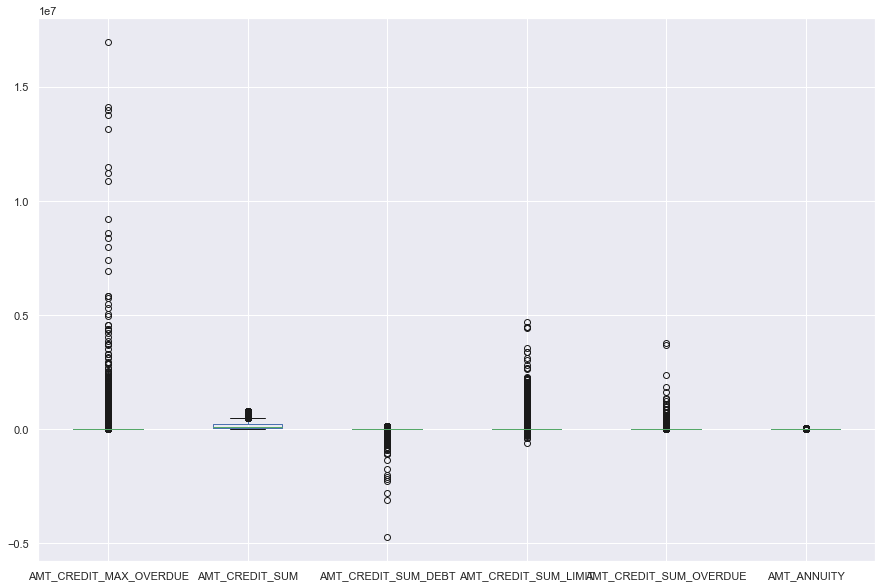

In [43]:
cols = ["AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
f, ax = plt.subplots(figsize=(15, 10))
bureau[cols].plot(kind="box", ax=ax)

In [40]:
bureau[bureau.AMT_CREDIT_SUM_DEBT < 0].shape[0]

8418

In [41]:
bureau[bureau.AMT_CREDIT_SUM_DEBT > 0].shape[0]

175093

Although I'm not certain that all the values are are correct, we'll leave things as they are for now, might return later.

In [44]:
bb = pd.read_csv('input/bureau_balance.csv')
print("bureau balance data size:", bb.shape)
bb.head()

bureau balance data size: (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [45]:
bb.dtypes.value_counts()

int64     2
object    1
dtype: int64

- This table gives us each loan's status for a specific month relative to the its application date.
- The statuses carry a variety of meanings, I suspect we'll be creating some new features based on these later.

In [47]:
bb.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

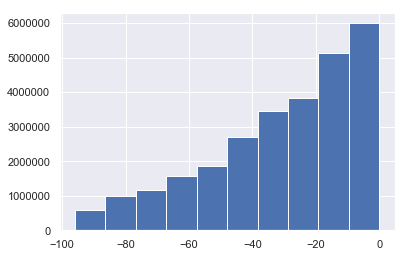

In [48]:
bb.MONTHS_BALANCE.hist()

Doesn't look like we need to do anything here.

## Previous Applications

In [49]:
previous = pd.read_csv('input/previous_application.csv')
print("previous applications data size:", previous.shape)
previous.head()

previous applications data size: (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
previous.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023418221710>,
      dtype=object)

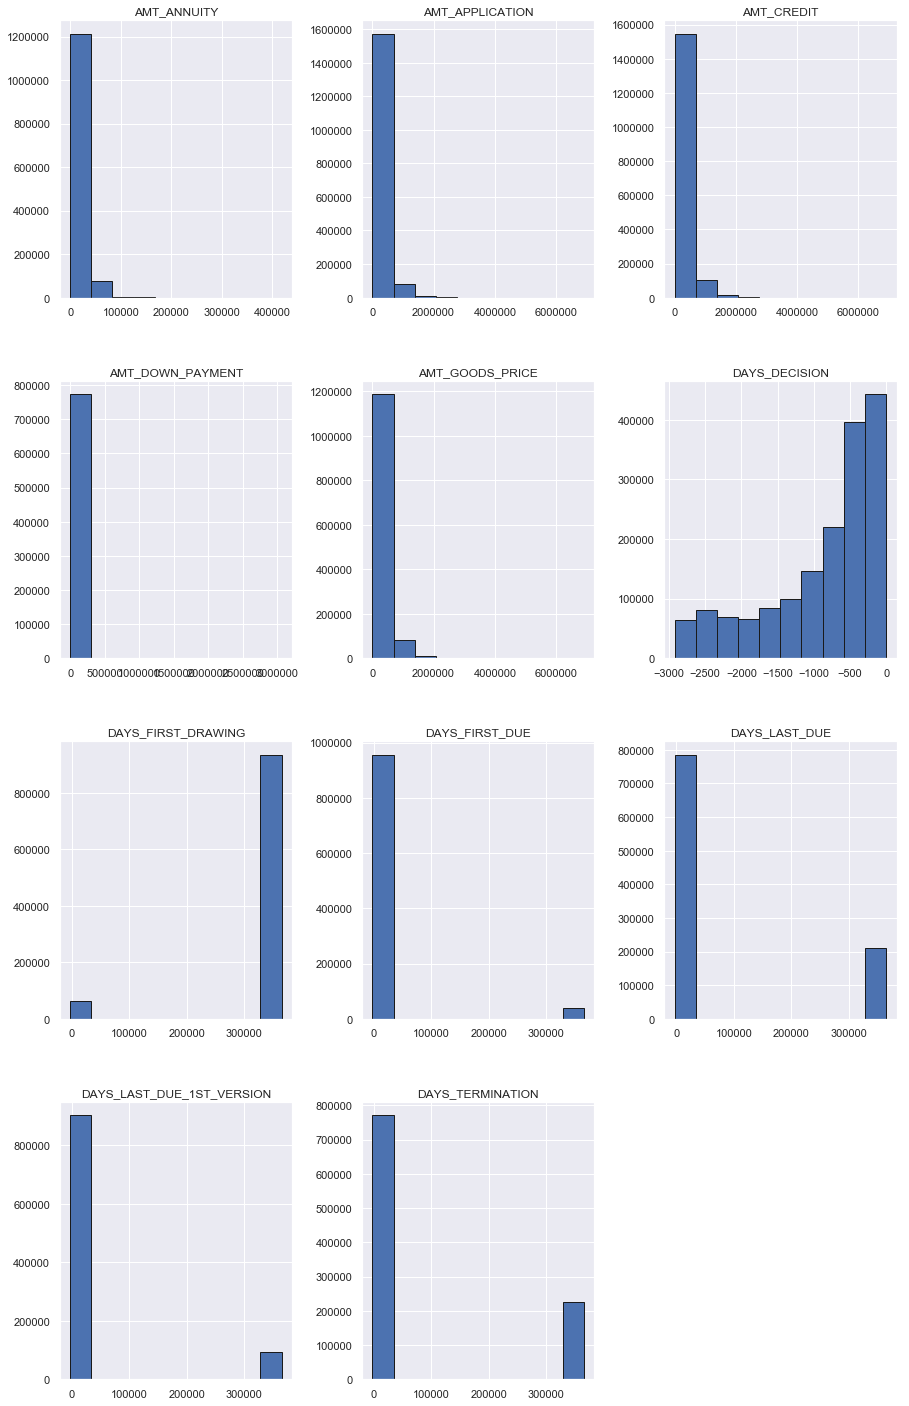

In [70]:
cols = ["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "DAYS_DECISION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]
f, ax = plt.subplots(figsize=(15,25))
previous[cols].hist(ax=ax, edgecolor='k')

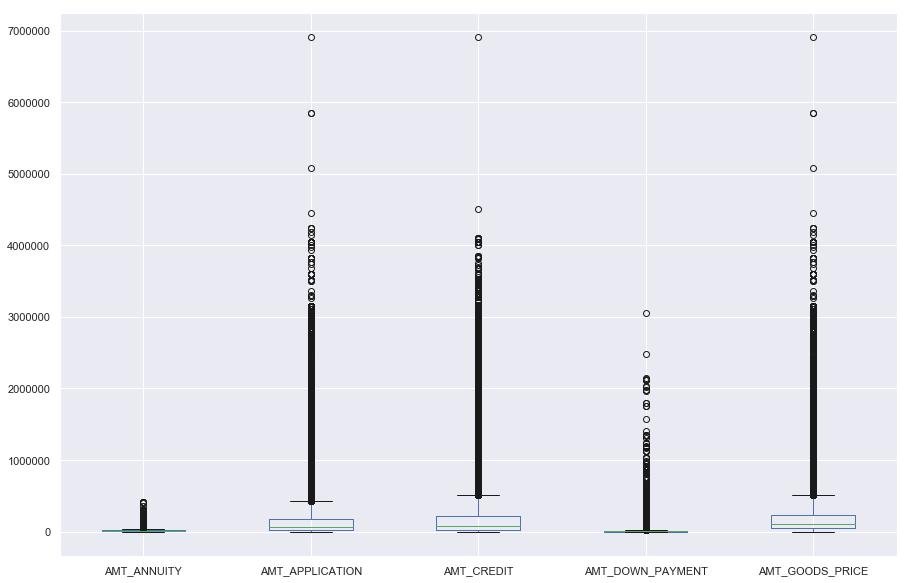

In [74]:
cols = ["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]#, "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]
f, ax = plt.subplots(figsize=(15,10))
previous[cols].plot(kind="box", ax=ax)

Once again I'll replace 3 x IQR outliers with `np.nan`

In [77]:
cols = ["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]
iqr = previous[cols].describe().loc["75%"] - previous[cols].describe().loc["25%"]

previous.loc[previous[previous.AMT_ANNUITY >= 3 * iqr.AMT_ANNUITY].index, "AMT_ANNUITY"] = np.nan
previous.loc[previous[previous.AMT_APPLICATION >= 3 * iqr.AMT_APPLICATION].index, "AMT_APPLICATION"] = np.nan
previous.loc[previous[previous.AMT_CREDIT >= 3 * iqr.AMT_CREDIT].index, "AMT_CREDIT"] = np.nan
previous.loc[previous[previous.AMT_DOWN_PAYMENT >= 3 * iqr.AMT_DOWN_PAYMENT].index, "AMT_DOWN_PAYMENT"] = np.nan
previous.loc[previous[previous.AMT_GOODS_PRICE >= 3 * iqr.AMT_GOODS_PRICE].index, "AMT_GOODS_PRICE"] = np.nan

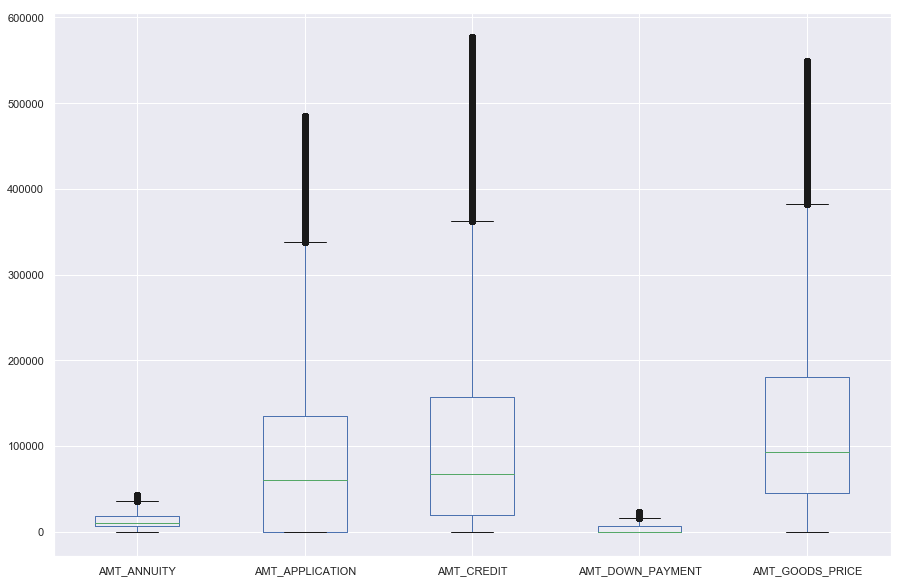

In [79]:
cols = ["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]#, "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]
f, ax = plt.subplots(figsize=(15,10))
previous[cols].plot(kind="box", ax=ax)

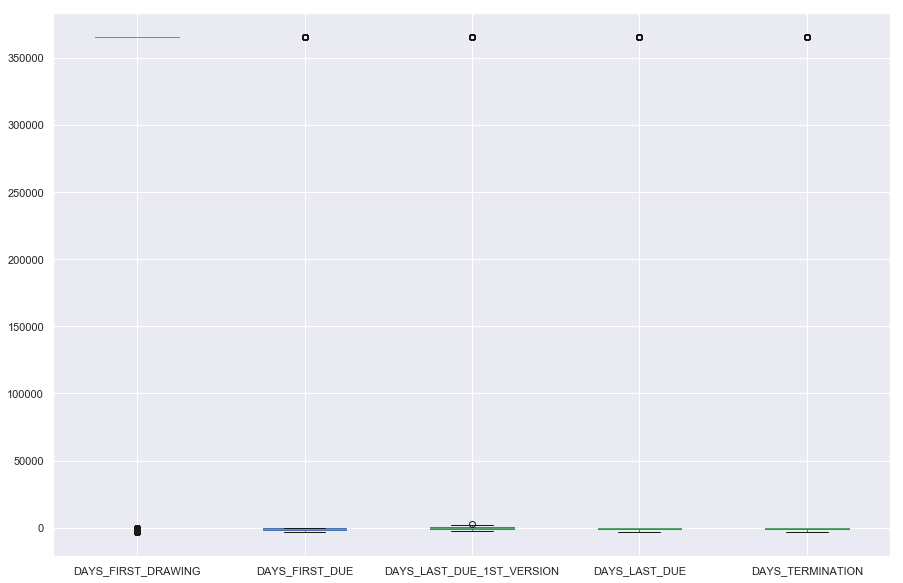

In [82]:
cols = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]
f, ax = plt.subplots(figsize=(15,10))
previous[cols].plot(kind="box", ax=ax)

In [81]:
previous[cols].describe()

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838
std,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729
min,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000
25%,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000
50%,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000
75%,365243.000000,-411.000000,129.000000,-74.000000,-44.000000
max,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000


All day fields have the same extreme and incorrect value as their maximum, we'll replace this with `np.nan`

In [85]:
previous["DAYS_FIRST_DRAWING"].replace({365243: np.nan}, inplace=True)
previous["DAYS_FIRST_DUE"].replace({365243: np.nan}, inplace=True)
previous["DAYS_LAST_DUE_1ST_VERSION"].replace({365243: np.nan}, inplace=True)
previous["DAYS_LAST_DUE"].replace({365243: np.nan}, inplace=True)
previous["DAYS_TERMINATION"].replace({365243: np.nan}, inplace=True)

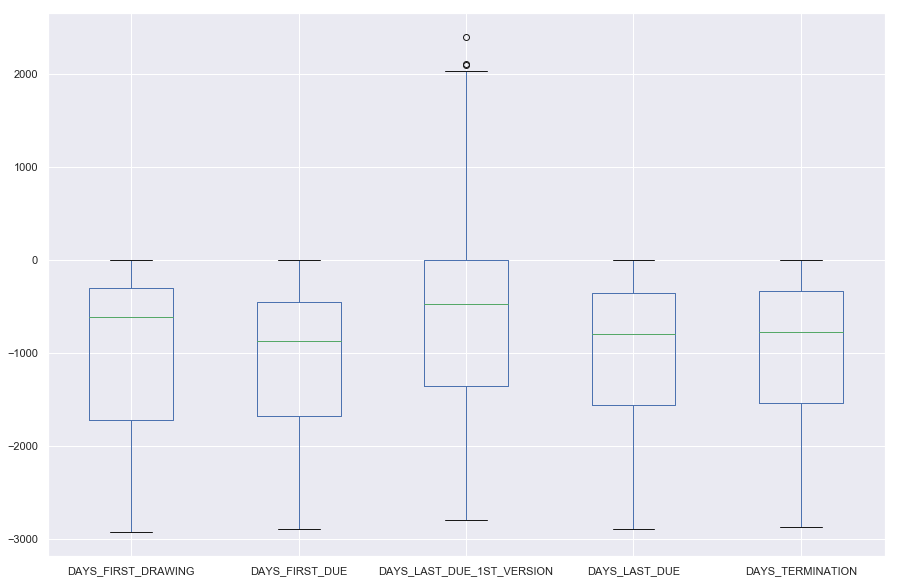

In [86]:
cols = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"]
f, ax = plt.subplots(figsize=(15,10))
previous[cols].plot(kind="box", ax=ax)

## Point of Sales

In [87]:
pos = pd.read_csv('input/POS_CASH_balance.csv')
print("pos data size:", pos.shape)
pos.head()

pos data size: (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [88]:
pos.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

## Instalment Payments

## Credit Card Balances

# Data Merging

Now that we've cleaned up each dataset, we need to aggregate the data in the child tables and merge it with our main application table.